# Import Library

In [1]:
from IPython.display import display
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import string
import math
import warnings
warnings.filterwarnings("ignore")

## Set parameters

In [2]:
N_LIST =  [5,15,25,35,45,55,65,75,85,95]
M = 40
K = 4
LBP_LEN = 1
USE_TF_IDF = True
USE_MODULE_INFO = False
USE_CLUSTER = True

# Load Dataset

In [3]:
studentVle = pd.read_csv('data/our_dataset.csv')
studentVle.head()

,id_student,course_id,activity_type,id_site,ts
0,3151,27,NO_ACTION,-1,2021-03-01 00:02:38
1,3151,27,NO_ACTION,-1,2021-03-01 00:07:39
2,3151,27,NO_ACTION,-1,2021-03-01 00:12:40
3,3151,27,NO_ACTION,-1,2021-03-01 00:17:41
4,8727,26,LOGIN,-1,2021-03-01 00:38:52


## Generate Basic Data

In [4]:
def generate_uppercase_sequence(length):
    uppercase_letters = string.ascii_uppercase
    sequence = []
    for i in range(length):
        sequence.append(uppercase_letters[i % 26])
    return sequence

def get_seq(one_seq):
    one_real_seq = []
    for one in one_seq:
        one_real_seq.append(event_code_A[one])
    return one_real_seq

In [5]:
all_act_type = list(studentVle['activity_type'].value_counts().index)
event_code = dict(zip(all_act_type,generate_uppercase_sequence(len(all_act_type))))
event_code_A = dict(zip(generate_uppercase_sequence(len(all_act_type)),all_act_type))
studentVle['event_code'] = studentVle['activity_type'].map(event_code)
studentVle.index = list(studentVle['id_student'])
studentVle.head()

,id_student,course_id,activity_type,id_site,ts,event_code
3151,3151,27,NO_ACTION,-1,2021-03-01 00:02:38,P
3151,3151,27,NO_ACTION,-1,2021-03-01 00:07:39,P
3151,3151,27,NO_ACTION,-1,2021-03-01 00:12:40,P
3151,3151,27,NO_ACTION,-1,2021-03-01 00:17:41,P
8727,8727,26,LOGIN,-1,2021-03-01 00:38:52,K


# Generate learner feature matrix

## Obtain student course selection information

In [6]:
student_module = studentVle[['course_id','id_student']].drop_duplicates()
studentInfo_one_hot = pd.get_dummies(student_module,columns=['course_id'])
studentInfo_one_hot = studentInfo_one_hot.groupby('id_student').sum()
studentInfo_one_hot.index = list(studentInfo_one_hot.index)
studentInfo_one_hot.head()

,course_id_26,course_id_27,course_id_72,course_id_73
8,1,1,1,1
13,1,0,0,1
21,1,0,1,0
23,1,0,1,0
33,1,1,1,1


## Extracting learner behavior sequences

In [8]:
all_seq_data = {}
stu_resource = {}
need_stu_have = list(studentVle['id_student'].value_counts().index)
for one_stu in tqdm(need_stu_have):
    one_stu_data = studentVle.loc[one_stu].copy()
    one_num = dict(one_stu_data['activity_type'].value_counts())
    one_stu_play = one_stu_data[one_stu_data['activity_type']=='VIDEO_PLAY'].copy()
    one_stu_res = dict(one_stu_play['id_site'].value_counts())
    stu_resource[one_stu] = one_stu_res
    all_seq_data[one_stu] = list(one_stu_data['event_code'])
# pd.to_pickle(stu_resource,'data/process_data/our_stu_resource.plk')
# pd.to_pickle(all_seq_data,'data/process_data/our_all_seq_data.plk')

100%|██████████| 4595/4595 [01:25<00:00, 53.54it/s]


In [9]:
# stu_resource = pd.read_pickle('data/process_data/our_stu_resource.plk')
# all_seq_data = pd.read_pickle('data/process_data/our_all_seq_data.plk')
# print(len(list(all_seq_data.keys())))

## Extracting Learning Behavior Patterns

In [10]:
def sort_dict(one_dict,reverse=True):
    return dict(sorted(one_dict.items(), key=lambda x: x[1],reverse=True))

def get_dup_seq(one_seq,k):
    one_dup_seq = {}
    for i in range(len(one_seq) - k + 1):
        subseq = one_seq[i:i+k]
        seq_click = 1
        if subseq in one_dup_seq:
            one_dup_seq[subseq] += seq_click
        else:
            one_dup_seq[subseq] = seq_click
    one_dup_seq = sort_dict(one_dup_seq)
    return one_dup_seq

In [11]:
all_stu_seq = {}
all_seq_num = {}
for one_stu,one_seq in tqdm(all_seq_data.items()):
    all_stu_seq[one_stu] = {}
    one_dup_seq = get_dup_seq(''.join(one_seq),LBP_LEN)
    all_stu_seq[one_stu] = one_dup_seq
    for one_sub_key in one_dup_seq.keys():
        if one_sub_key in all_seq_num:
            all_seq_num[one_sub_key] += 1
        else:
            all_seq_num[one_sub_key] = 1
if LBP_LEN >2:
    all_seq_num = {k:v for k, v in all_seq_num.items() if v>=100}

100%|██████████| 4595/4595 [00:02<00:00, 2037.05it/s]


## Calculate TF-IDF value

In [12]:
all_stu_num = len(all_seq_data.keys())
seq_IDF = [math.log(all_stu_num/(one+1),10) for one in list(all_seq_num.values())]
all_seq_IDF = dict(zip(list(all_seq_num.keys()),seq_IDF))
stu_TF_IDF = {}
for key,sub_seq in tqdm(all_stu_seq.items()):
    one_stu_TF_IDF = {}
    seq_all_num = sum(list(sub_seq.values()))
    for sub_k,sub_v in sub_seq.items():
        if sub_k not in all_seq_IDF:
            continue
        one_TF = sub_v/seq_all_num
        one_stu_TF_IDF[sub_k] = all_seq_IDF[sub_k]*one_TF
    stu_TF_IDF[key] = one_stu_TF_IDF

100%|██████████| 4595/4595 [00:00<00:00, 136221.05it/s]


In [13]:
need_feature = dict(zip(list(all_seq_num.keys()),[0]*len(all_seq_num)))
all_feature_values = []
for one_stu,one_TF_IDF in tqdm(stu_TF_IDF.items()):
    one_need_feature = need_feature.copy()
    if USE_TF_IDF:
        one_need_feature.update(one_TF_IDF)
    else:
        one_need_feature.update(all_stu_seq[one_stu])
    all_feature_values.append(one_need_feature)
stu_id_index = list(stu_TF_IDF.keys())
my_data = pd.DataFrame(all_feature_values,index=stu_id_index)
my_data.head()

100%|██████████| 4595/4595 [00:00<00:00, 753698.60it/s]


,A,F,D,B,C,G,L,N,K,E,...,J,M,H,T,U,R,Q,S,O,P
21730,-0.000016,0.001484,-0.000013,-0.000011,-0.000011,0.0,0.002764,0.000442,-3.187370e-06,0.0,...,0.0,0.000023,0.000007,0.000324,0.000129,0.000119,0.000071,0.000149,0.000029,0.000076
11419,-0.000021,0.000398,-0.000008,-0.000021,-0.000021,0.0,0.000156,0.000200,-7.494527e-07,0.0,...,0.0,0.000072,0.000039,0.000079,0.000114,0.000810,0.000653,0.001303,0.000181,0.000322
1262,-0.000002,0.000117,-0.000023,-0.000002,-0.000002,0.0,0.015768,0.000003,-1.845090e-07,0.0,...,0.0,0.000005,0.000010,0.000981,0.000000,0.000000,0.000085,0.002930,0.000077,0.008968
15885,-0.000023,0.000134,-0.000008,-0.000023,-0.000023,0.0,0.000143,0.000163,-2.964418e-07,0.0,...,0.0,0.000076,0.000034,0.000000,0.000021,0.000549,0.000690,0.000050,0.000023,0.000201
20154,-0.000023,0.000334,-0.000008,-0.000023,-0.000022,0.0,0.000241,0.000116,-6.023843e-07,0.0,...,0.0,0.000063,0.000031,0.000172,0.000076,0.000291,0.000818,0.000000,0.000049,0.000035


## Load student course selection information

In [14]:
if USE_MODULE_INFO:
    my_data = pd.concat([my_data,studentInfo_one_hot.loc[stu_id_index]],join='inner',axis=1)
    my_data.head()

# Learner clustering

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
if USE_CLUSTER:
    tsne = manifold.TSNE(n_components=2,learning_rate='auto', init='pca', random_state=42).fit_transform(my_data)
    KM_cluster = KMeans(init='k-means++', n_clusters=K,random_state=2023)
    KM_cluster.fit(tsne)
    all_labels = list(KM_cluster.labels_)
    stu_2_cluster = dict(zip(stu_id_index,all_labels))

# Recommendation of learning resources

## Calculate learner similarity

In [16]:
import time
start_time = time.time()
all_stu_pearson = {}
if USE_CLUSTER:
    cluster_data = my_data.copy()
    cluster_data['cluster'] = all_labels
    nee_col = list(cluster_data.columns[:-1])
    for one_cluster in tqdm(range(K)):
        one_clus_data = cluster_data[cluster_data['cluster']==one_cluster][nee_col]
        all_stu_pearson[one_cluster] = one_clus_data.T.corr(method='pearson')
    display(all_stu_pearson[0].head())
else:
    all_stu_pearson =  my_data.T.corr(method='pearson')
    display(all_stu_pearson.head())
end_time = time.time()
run_time = end_time - start_time
print('run time：',run_time)

100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


,11419,8332,23729,5551,8820,8727,11407,1795,9307,18655,...,17510,8461,4985,1588,6011,10047,18310,4479,12496,24139
11419,1.000000,0.812388,0.247359,0.799579,0.422005,0.837168,0.700872,0.789362,0.762167,0.652128,...,0.864221,0.756243,0.709364,0.714836,0.697450,0.585324,0.113894,0.742443,0.893199,0.111598
8332,0.812388,1.000000,0.657413,0.728397,0.601057,0.797986,0.835132,0.727328,0.817616,0.787966,...,0.795060,0.655665,0.742491,0.701866,0.696688,0.738599,0.403357,0.755099,0.755455,0.404369
23729,0.247359,0.657413,1.000000,0.319334,0.582154,0.462283,0.705446,0.517995,0.438191,0.396816,...,0.426975,0.283017,0.546301,0.251502,0.602669,0.712597,0.769342,0.549703,0.247177,0.825336
5551,0.799579,0.728397,0.319334,1.000000,0.270100,0.946657,0.777341,0.732314,0.781264,0.868291,...,0.866600,0.993063,0.916265,0.904795,0.597254,0.722843,0.199248,0.934948,0.918487,0.189761
8820,0.422005,0.601057,0.582154,0.270100,1.000000,0.426843,0.717547,0.559157,0.146094,0.138211,...,0.376001,0.226575,0.541556,0.027251,0.722574,0.716052,0.792111,0.435577,0.486061,0.750547


run time： 0.41902780532836914


## Calculate learners' interest in learning resources

In [17]:
all_stu_sim_resource = {}
for one_stu in tqdm(stu_id_index):
    if USE_CLUSTER:
        one_cluster = stu_2_cluster[one_stu]
        k_person = dict(all_stu_pearson[one_cluster].loc[one_stu].sort_values(ascending=False)[:M+1])
    else:
        k_person = dict(all_stu_pearson.loc[one_stu].sort_values(ascending=False)[:M+1])
    k_person[one_stu] = 10
    del k_person[one_stu]
    one_stu_resource = {}
    for sim_stu,sim in k_person.items():
        one_sim_stu_resource = list(stu_resource[sim_stu].keys())
        for one_resource in one_sim_stu_resource:
            if one_resource not in one_stu_resource:
                one_stu_resource[one_resource] = 0
            one_stu_resource[one_resource] += sim
    all_stu_sim_resource[one_stu] = sorted(one_stu_resource.items(), key= lambda k:k[1], reverse=True)

100%|██████████| 4595/4595 [00:07<00:00, 598.33it/s]


## Top N learning resource recommendations

In [18]:
all_re = []
for top_n in tqdm(N_LIST):
    all_stu_rec_video = {}
    for one_stu in stu_id_index:
        all_stu_rec_video[one_stu] = all_stu_sim_resource[one_stu][:top_n]
    all_recall = []
    all_pre = []
    all_f1 = []
    for one_stu in stu_id_index:
        one_train_video = list(stu_resource[one_stu].keys())
        one_hit = 0
        for one in all_stu_rec_video[one_stu]:
            if one[0] in one_train_video:
                one_hit += 1
        one_recall = one_hit/len(one_train_video)
        all_recall.append(one_recall)
        if len(all_stu_rec_video[one_stu])==0:
            print(one_stu)
        one_pre = one_hit/len(all_stu_rec_video[one_stu])
        all_pre.append(one_pre)
        if (one_recall+one_pre)==0:
            one_f1 = 0
        else:
            one_f1 = (2*one_recall*one_pre)/(one_recall+one_pre)
        all_f1.append(one_f1)
    all_recall_1 = np.mean(all_recall)
    all_pre_1 = np.mean(all_pre)
    all_f1_1 = np.mean(all_f1)
    one_re = {'Top-N':top_n,'Precision':all_pre_1,'Recall':all_recall_1,'F1':all_f1_1,}
    all_re.append(one_re)
all_re_set = pd.DataFrame(all_re)
all_re_set.index = list(all_re_set['Top-N'])
all_re_set.to_csv(f'log/our_dataset/K.{K}-LBP.{LBP_LEN}-TF.{USE_TF_IDF}-MODULE.{USE_MODULE_INFO}-CLUSTER.{USE_CLUSTER}.csv',index=False)
all_re_set.head(20)

100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


,Top-N,Precision,Recall,F1
5,5,0.491665,0.046841,0.083763
15,15,0.444512,0.124318,0.186684
25,25,0.416601,0.191807,0.250173
35,35,0.392010,0.250143,0.289470
45,45,0.370296,0.300784,0.313818
55,55,0.350777,0.345436,0.328658
65,65,0.332043,0.383646,0.335941
75,75,0.314960,0.416195,0.338340
85,85,0.299323,0.444625,0.337658
95,95,0.284719,0.469525,0.334711


## Visualization of results

Text(0, 0.5, 'Value')

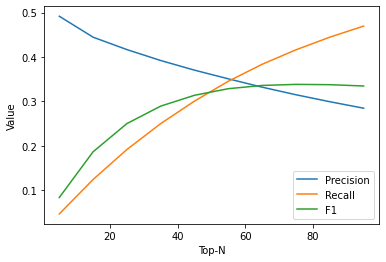

In [19]:
all_re_set_plt = all_re_set[['Precision','Recall','F1']]
one_plot = all_re_set_plt.plot()
one_plot.set_xlabel('Top-N')
one_plot.set_ylabel('Value')